In [224]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
tf.compat.v1.logging.set_verbosity
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import warnings
warnings.simplefilter('ignore')
pd.set_option('mode.chained_assignment', None)
warnings.simplefilter(action='ignore', category=FutureWarning)
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
# Importing Training Set
dataset_train = pd.read_csv('maybe4.csv')
# Select features
cols = list(dataset_train)[1:4]
# getting daates
datelist_train = list(dataset_train['Dates'])
datelist_train = [dt.datetime.strptime(date, '%m/%d/%Y').date() for date in datelist_train]
print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))


Training set shape == (2892, 4)
All timestamps == 2892
Featured selected: ['XAU Curncy', 'USGG10YR Index', 'GLD US Equity']


,1208.93,2.9733,-11.7515
0,1192.60,2.9302,-105.2434
1,1202.78,2.9803,-105.2434
2,1198.25,3.0306,-105.2434
3,1211.71,3.0520,-164.3472
4,1196.85,3.0628,-152.5579
...,...,...,...
2886,1807.11,1.2327,-5210.4645
2887,1828.17,1.2693,-4868.1282
2888,1814.19,1.2223,-4868.1282
2889,1813.47,1.1773,-4969.8222


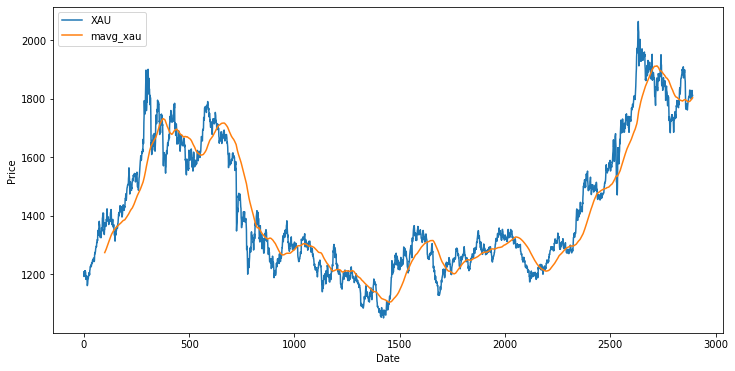

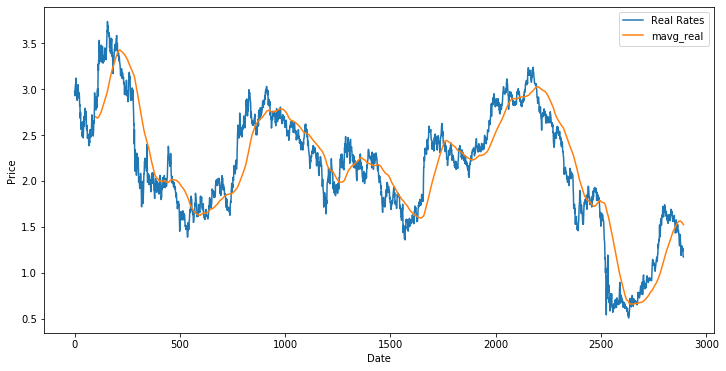

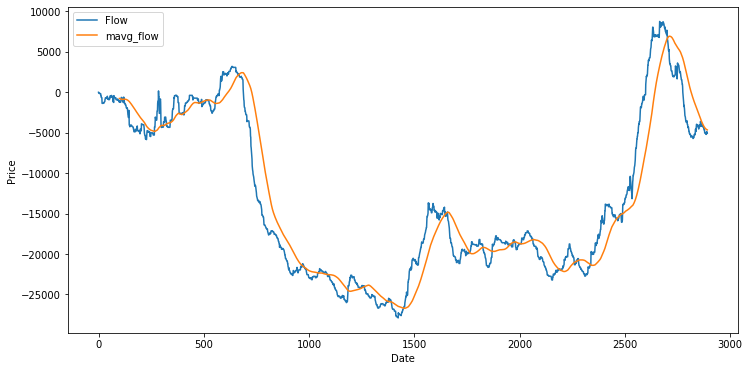

In [177]:
close_px = dataset_train['XAU Curncy']
last_px = dataset_train['USGG10YR Index']
flow_px = dataset_train['GLD US Equity']
mavg = close_px.rolling(window=100).mean()

plt.figure(figsize = (12,6))
close_px.plot(label='XAU')
mavg.plot(label='mavg_xau')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

mavg = last_px.rolling(window=100).mean()
plt.figure(figsize = (12,6))
last_px.plot(label='Real Rates')
mavg.plot(label='mavg_real')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

mavg = flow_px.rolling(window=100).mean()
plt.figure(figsize = (12,6))
flow_px.plot(label='Flow')
mavg.plot(label='mavg_flow')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()


In [178]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)
training_set = dataset_train.values

print('Shape of training set == {}.'.format(training_set.shape))
training_set
# Scaling
sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)
sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

Shape of training set == (2892, 3).


array([[-0.92494939],
       [-0.99690335],
       [-0.95204779],
       ...,
       [ 1.74197361],
       [ 1.73880111],
       [ 1.72545019]])

In [179]:
# Creating a dataset with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 60  # future prediction
n_past = 90     # lagged data

for i in range(n_past, len(training_set_scaled) - n_future + 1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (2743, 90, 2).
y_train shape == (2743, 1).


Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 90, 64)            17152     
_________________________________________________________________
lstm_45 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 33        
Total params: 29,601
Trainable params: 29,601
Non-trainable params: 0
_________________________________________________________________
Train on 2740 samples, validate on 3 samples
Epoch 1/20
2740/2740 [==============================] - 4s 1ms/sample - loss: 0.3301 - val_loss: 0.0212
Epoch 2/20
2740/2740 [==============================] - 2s 753us/sample - loss: 0.2005 - val_loss: 0.0393
Epoch 3/20
2740/2740 [==============================] - 2s 770us/sample - loss: 0.1758 - val_loss: 0.1487
Epoch 4/20
2740/27

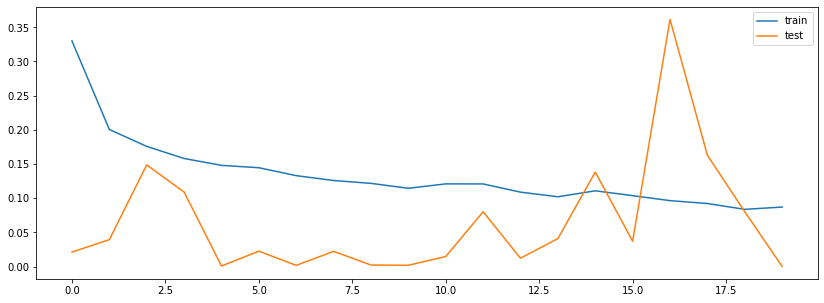

In [180]:
model = Sequential()
model.add((LSTM(64, return_sequences=True, dropout=0.5, input_shape=(n_past, dataset_train.shape[1]-1))))
model.add((LSTM(32,return_sequences=False,dropout=0.5)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
history = model.fit(X_train, y_train, shuffle= True, epochs=20, validation_split = 0.001, verbose=1, batch_size=150)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

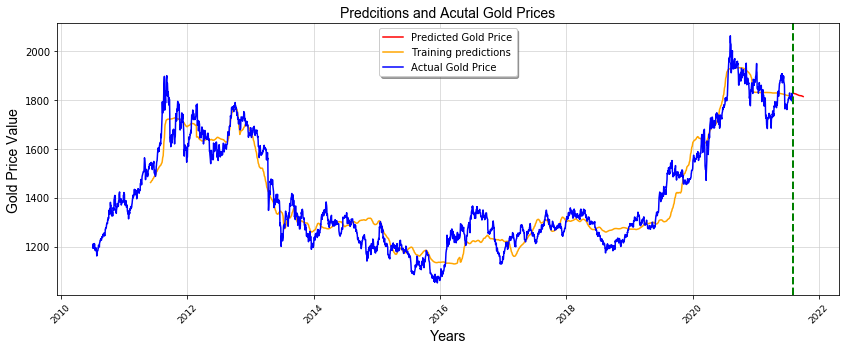

,Close
2021-07-21,1817.431396
2021-07-22,1817.099854
2021-07-23,1816.795410
2021-07-26,1816.513794
2021-07-27,1816.305786
2021-07-28,1816.134888
2021-07-29,1815.866333
2021-07-30,1815.570190
2021-08-02,1815.185181
2021-08-03,1814.728760


In [181]:
import torch
from torch import nn, optim
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

predictions_future = model.predict(X_train[-n_future:])
predictions_train = model.predict(X_train[n_past:])
def datetime_to_timestamp(x):
     return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')

y_pred_futur = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

pre_f = pd.DataFrame(y_pred_futur, columns=['Close']).set_index(pd.Series(datelist_future))
pre_tr = pd.DataFrame(y_pred_train, columns=['Close']).set_index(pd.Series(datelist_train[2 * n_pas + n_future -1:]))
pre_tr.index = pre_tr.index.to_series().apply(datetime_to_timestamp)
rcParams['figure.figsize'] = 14,5
#Plot parameters
plt.plot(pre_f.index, pre_f['Close'], color='r', label='Predicted Gold Price')
plt.plot(pre_tr.loc['07/05/2010':].index, pre_tr.loc['07/05/2010':]['Close'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc['07/05/2010':].index, dataset_train.loc['07/05/2010':]['XAU Curncy'], color='b', label='Actual Gold Price')

plt.axvline(x = min(pre_f.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.8)
plt.legend(shadow=True)
plt.title('Predcitions and Acutal Gold Prices', family='Arial', fontsize=14)
plt.xlabel('Years', family='Arial', fontsize=14)
plt.ylabel('Gold Price Value', family='Arial', fontsize=14)
plt.xticks(rotation=45, fontsize=9)
plt.show()
pre_tr.tail(10)

In [191]:
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 15
n_days_for_prediction= 15  #let us predict past 15 days

predict_period_dates = pd.date_range(list(datelist_train)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
#print(predict_period_dates)
prediction = model.predict(X_train[-n_days_for_prediction:]) 
prediction_copies = np.repeat(prediction, training_set_scaled.shape[1], axis=-1)
y_pred_future = sc.inverse_transform(prediction_copies)[:,0]


# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Dates':np.array(forecast_dates), 'XAU Curncy':y_pred_future})
df_forecast['Dates']=pd.to_datetime(df_forecast['Dates'])


#original = dataset_train[['Dates', 'XAU Curncy']]
#original['Dates']=pd.to_datetime(original['Dates'])
#original = original.loc[original['Dates'] >= '2021-07-20']

#sns.lineplot(original['Dates'], original['XAU Curncy'])
#sns.lineplot(df_forecast['Dates'], df_forecast['XAU Curncy'])
#plt.plot(df_forecast['XAU Curncy'], marker='.', label="true")
#plt.plot(oringinal, 'r', label="prediction")
#plt.ylabel('Value')
#plt.xlabel('Time Step')
#plt.legend()
#plt.show();
##plt.plot(df_forecast.index, df_forecast['Close'], color='r', label='Predicted Gold Price')
df_forecast.tail()

,Dates,XAU Curncy
10,2021-07-28,1816.134888
11,2021-07-29,1815.866333
12,2021-07-30,1815.570190
13,2021-08-02,1815.185181
14,2021-08-03,1814.728760


In [228]:
with torch.no_grad():
    test_seq = dataset_train[0:3]
    tf.keras.preprocessing.sequence.pad_sequences(dataset_train, maxlen=None, dtype='int32', padding='pre', truncating='pre', value=0.0
)
preds = []
for _ in range(12):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()
    
predicted_cases = scaler.inverse_transform(np.expand_dims(preds, axis=0)).flatten()   

daily_cases.index[-1]

predicted_index = pd.date_range(start=daily_cases.index[-1],periods=DAYS_TO_PREDICT + 1,closed='right')

predicted_cases = pd.Series(data=predicted_cases, index=predicted_index)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

ValueError: invalid literal for int() with base 10: 'Dates'

In [221]:
df[0:5]

,Dates,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,7/5/2010,1208.93,2.9733,-11.7515
1,7/6/2010,1192.6,2.9302,-105.2434
2,7/7/2010,1202.78,2.9803,-105.2434
3,7/8/2010,1198.25,3/3/2006,-105.2434
4,7/9/2010,1211.71,3/5/2002,-164.3472
